# Passo 1: Conectar ao GitHub

In [1]:
# Clonar o repositório GitHub para o projeto
!git clone https://github.com/Iaquine/Logo-Classification-with-CNN-and-Transfer-Learning.git

Cloning into 'Logo-Classification-with-CNN-and-Transfer-Learning'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [2]:
%cd /content/Logo-Classification-with-CNN-and-Transfer-Learning


/content/Logo-Classification-with-CNN-and-Transfer-Learning


# Passo 2: Configurações e Bibliotecas

In [3]:
# Instalações de bibliotecas essenciais
!pip install tensorflow keras matplotlib pandas scikit-learn

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
from glob import glob
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D




# Passo 3: Carregar e Preparar o Dataset
Usarei o dataset mencionado no Kaggle para realizar uma análise exploratória básica e preparar os dados.

In [5]:
# Primeiro, carregamos o kaggle.json, que contém as credenciais da API
from google.colab import files
files.upload()  # Faz upload do kaggle.json

# Configurações do Kaggle no ambiente Colab
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa e descompacta o dataset
!kaggle datasets download -d kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
!unzip logos-bk-kfc-mcdonald-starbucks-subway-none.zip -d data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
License(s): DbCL-1.0
 88% 57.0M/65.0M [00:00<00:00, 172MB/s]
100% 65.0M/65.0M [00:00<00:00, 162MB/s]
Archive:  logos-bk-kfc-mcdonald-starbucks-subway-none.zip
  inflating: data/logos3/test/Burger King/armada_image_100.jpg  
  inflating: data/logos3/test/Burger King/armada_image_100_2.jpg  
  inflating: data/logos3/test/Burger King/armada_image_101.jpg  
  inflating: data/logos3/test/Burger King/armada_image_102.jpg  
  inflating: data/logos3/test/Burger King/armada_image_103.jpg  
  inflating: data/logos3/test/Burger King/armada_image_3.jpg  
  inflating: data/logos3/test/Burger King/armada_image_4.jpg  
  inflating: data/logos3/test/Burger King/armada_image_444.jpg  
  inflating: data/logos3/test/Burger King/armada_image_445.jpg  
  inflating: data/logos3/test/Burger King/armada_image_446.jpg  
  inflating: data/logos3/test/Burger King/armada_image_447.

In [6]:
train_data_dir = "data/logos3/train"
test_data_dir = "data/logos3/test"
classes = ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']

# Passo 4: Preparação dos Dados
Dividimos os dados em conjuntos de treino, validação e teste, aplicando algumas transformações que ajudarão o modelo a generalizar melhor, como aumentos de imagem (data augmentation).


Classe Burger King: 297 imagens (treino)
Classe KFC: 70 imagens (treino)
Classe McDonalds: 189 imagens (treino)
Classe Other: 825 imagens (treino)
Classe Starbucks: 233 imagens (treino)
Classe Subway: 124 imagens (treino)
Classe Burger King: 153 imagens (teste)
Classe KFC: 20 imagens (teste)
Classe McDonalds: 96 imagens (teste)
Classe Other: 224 imagens (teste)
Classe Starbucks: 38 imagens (teste)
Classe Subway: 29 imagens (teste)


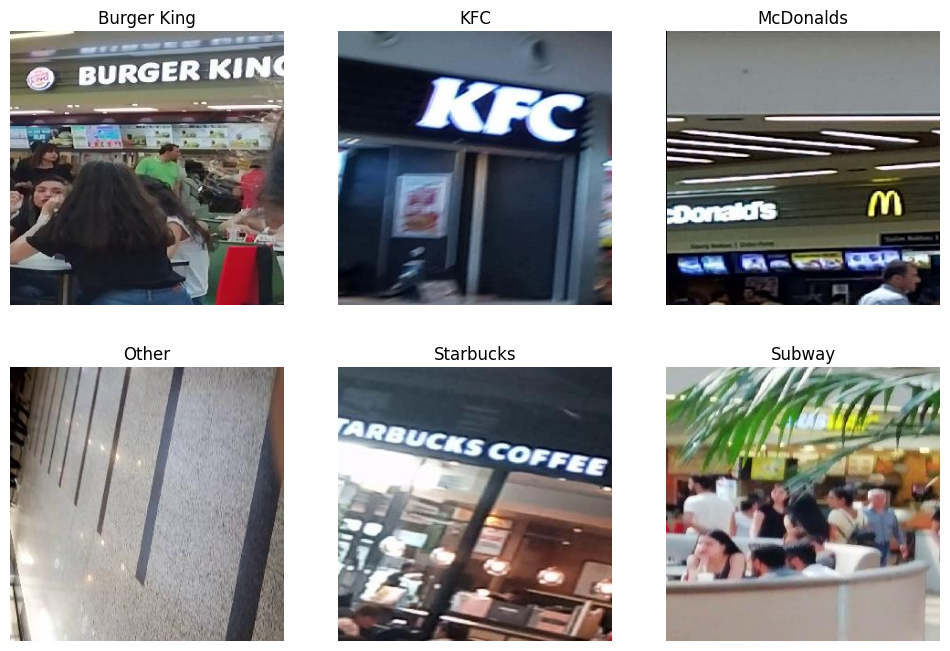

In [7]:
# Análise exploratória básica
# Imprimir número de imagens em cada classe (treino)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f'Classe {class_name}: {num_images} imagens (treino)')

# Imprimir número de imagens em cada classe (teste)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f'Classe {class_name}: {num_images} imagens (teste)')

# Mostrar algumas imagens de cada classe (treino)
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(classes):
    class_path = os.path.join(train_data_dir, class_name)
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = plt.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [8]:
# Definindo hiperparâmetros e dimensões das imagens
batch_size = 32
img_height, img_width = 224, 224

# Configuração de data augmentation e carregamento dos dados
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical" )

val_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical" )

Found 1738 images belonging to 6 classes.
Found 560 images belonging to 6 classes.


# Passo 4: Implementação do Modelo CNN
Aqui, implemento uma CNN do zero, estruturada para detectar padrões nas imagens das fachadas.

In [9]:
# Definindo a arquitetura do modelo CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(classes), activation="softmax")
])

model_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treinamento do modelo
history_cnn = model_cnn.fit(train_data, epochs=20, validation_data=val_data)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.4261 - loss: 1.6469 - val_accuracy: 0.5375 - val_loss: 1.3320
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.6837 - loss: 0.9365 - val_accuracy: 0.5232 - val_loss: 1.4356
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.7489 - loss: 0.6993 - val_accuracy: 0.5250 - val_loss: 1.8559
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.7416 - loss: 0.7619 - val_accuracy: 0.5554 - val_loss: 1.2945
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.7886 - loss: 0.6453 - val_accuracy: 0.5554 - val_loss: 1.6375
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.8247 - loss: 0.5134 - val_accuracy: 0.5929 - val_loss: 1.3630
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.8312 - loss: 0.5114 - val_accuracy: 0.5857 - val_loss: 1.3504
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.8545 - loss: 0.4440 - val_accuracy: 0.5768 - val_loss: 1.

# Passo 5: Implementação do Modelo com Transfer Learning
Para o segundo modelo, utilizo Transfer Learning com a arquitetura ResNet50 pré-treinada no ImageNet. Este modelo aproveita os recursos de aprendizado de uma rede já treinada para tarefas de classificação complexas.

In [10]:
# Carregar o modelo base ResNet50 pré-treinado
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False


# Adicionar as camadas finais para nosso problema de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation="softmax")(x)


model_tl = Model(inputs=base_model.input, outputs=predictions)
model_tl.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treinamento do modelo com Transfer Learning
history_tl = model_tl.fit(train_data, epochs=20, validation_data=val_data)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 457s 8s/step - accuracy: 0.4333 - loss: 1.6795 - val_accuracy: 0.5429 - val_loss: 1.2231
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 542s 9s/step - accuracy: 0.5824 - loss: 1.1865 - val_accuracy: 0.5929 - val_loss: 1.0993
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 491s 9s/step - accuracy: 0.6115 - loss: 1.0836 - val_accuracy: 0.6214 - val_loss: 1.0458
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 501s 9s/step - accuracy: 0.6390 - loss: 1.0132 - val_accuracy: 0.6411 - val_loss: 1.0319
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 471s 8s/step - accuracy: 0.6322 - loss: 0.9740 - val_accuracy: 0.6429 - val_loss: 1.0056
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 532s 9s/step - accuracy: 0.6298 - loss: 0.9901 - val_accuracy: 0.6357 - val_loss: 1.0125
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 467s 8s/step - accuracy: 0.6714 - loss: 0.8862 - val_accuracy: 0.6196 - val_loss: 1.0192
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 503s 8s/step - accurac

# Passo 6: Comparação de Desempenho
Avalio o desempenho dos dois modelos no conjunto de validação para comparar a eficácia. Posso utilizar métricas como accuracy, f1-score, entre outras.

In [11]:
cnn_val_loss, cnn_val_acc = model_cnn.evaluate(val_data)
print(f"CNN Model Loss: {cnn_val_loss}, Accuracy: {cnn_val_acc}")

# Avaliação do modelo com Transfer Learning
tl_val_loss, tl_val_acc = model_tl.evaluate(val_data)
print(f"Transfer Learning Model Loss: {tl_val_loss}, Accuracy: {tl_val_acc}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6536 - loss: 1.0576
CNN Model Loss: 1.144109845161438, Accuracy: 0.6303571462631226
18/18 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.6547 - loss: 1.0195
Transfer Learning Model Loss: 1.0027790069580078, Accuracy: 0.6517857313156128


# Consideraçoes finais:

Transfer learning geralmente apresenta melhores resultados em tarefas de classificação de imagens, especialmente quando o conjunto de dados é relativamente pequeno, como no caso do conjunto de dados de logotipos aqui usado.

- Aqui estão algumas razões pelas quais o transfer learning pode ter um desempenho melhor do que uma CNN treinada do zero:

1. Aproveitamento de conhecimento prévio: Modelos pré-treinados como o ResNet50 já aprenderam recursos hierárquicos complexos de um conjunto de dados muito maior (ImageNet). Esses recursos podem ser generalizados para outras tarefas de classificação de imagens, como a classificação de logotipos.

2. Eficiência de dados: Com transfer learning, precisamos de menos dados de treinamento para atingir um bom desempenho. Isso ocorre porque o modelo já possui uma boa compreensão dos recursos visuais básicos.

3. Tempo de treinamento reduzido: Como o modelo pré-treinado já possui uma base sólida, o tempo necessário para treinar as camadas adicionais para a tarefa específica é menor em comparação com o treinamento de uma CNN do zero.

4. Generalização aprimorada: O modelo pré-treinado foi exposto a uma variedade muito maior de imagens, tornando-o mais robusto e menos propenso a overfitting, especialmente em conjuntos de dados menores.

Aqui, o modelo ResNet50 usado para transfer learning foi pré-treinado no ImageNet, um conjunto de dados massivo com milhões de imagens. Esse conhecimento prévio ajudou o modelo a aprender a classificar os logotipos de forma mais eficaz, mesmo com um conjunto de dados menor. Além disso, o uso de data augmentation durante o treinamento provavelmente melhorou ainda mais a generalização do modelo.
